In [122]:
from scipy.io import loadmat
from scipy.sparse import find
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, to_tree, ClusterNode
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import adjusted_rand_score
import numpy as np
import numpy.linalg as lalg
import matplotlib.pyplot as plt
import matplotlib.gridspec as grsp
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from pickle import dump, load, HIGHEST_PROTOCOL
from collections import defaultdict
%matplotlib inline

# wrangle data

In [2]:
def largest_connected_component(G):
    G = G.subgraph(max(nx.connected_components(G), key=len))
    G = nx.relabel.convert_node_labels_to_integers(G, label_attribute='orig')
    return G

In [47]:
def wrangle_karate():
    mat = loadmat('karate.mat')
    S = mat['Problem'][0][0][2]
    G = nx.Graph(S)

    mr_hi = set([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22])
    split = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for i in G.nodes:
        split[i] = 0 if i+1 in mr_hi else 1
        cols[i] = cmap(0) if i+1 in mr_hi else cmap(0.1)
    nx.set_node_attributes(G, split, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'karate'
    return largest_connected_component(G)

In [4]:
def wrangle_football():
    # data fixed by Tim Evans
    mat = loadmat('football_fixed.mat')
    I,J = mat['links']
    G = nx.Graph()
    G.add_edges_from(zip(I,J))

    confs = {}
    cols = {}
    cmap = plt.get_cmap('tab20')
    for node in mat['nodes']:
        idx = int(node[0])
        conf = int(node[2])
        assert idx not in confs.keys()
        if conf>10:
            confs[idx] = conf
            cols[idx] = (0,0,0,1)
        else:
            confs[idx] = conf
            cols[idx] = cmap(conf/11)
    nx.set_node_attributes(G, confs, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'football'
    return largest_connected_component(G)

In [50]:
def wrangle_caltech():
    mat = loadmat('Caltech36.mat')
    G = nx.Graph(mat['A'])

    houses = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for i,x in enumerate(mat['local_info']):
        house = x[4]
        if house==0:
            houses[i] = house
            cols[i] = (0,0,0,1)
        else:
            houses[i] = house
            cols[i] = cmap((house-165)/10)
    nx.set_node_attributes(G, houses, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'caltech'
    return largest_connected_component(G)

In [51]:
def wrangle_lesmis():
    G = largest_connected_component(nx.les_miserables_graph())
    # no ground truth
    cmap = plt.get_cmap('tab10')
    nx.set_node_attributes(G, {i:0 for i in G.nodes}, 'cluster')
    nx.set_node_attributes(G, {i:cmap(0) for i in G.nodes}, 'color')
    return G

In [52]:
def generate_lfr():
    G = LFR_benchmark_graph(n=250, tau1=3, tau2=1.5, mu=.1, average_degree=5, min_community=20, seed=0)
    communities = nx.get_node_attributes(G, 'community')
    seen = set()
    clust_idx = 0
    clusts = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for idx,community in communities.items():
        if idx not in seen:
            for member in community:
                clusts[member] = clust_idx
                cols[member] = cmap(clust_idx/10)
                seen.add(member)
            clust_idx += 1
    nx.set_node_attributes(G, clusts, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.remove_edges_from(nx.selfloop_edges(G))
    G.graph['name'] = 'lfr'
    return largest_connected_component(G)

# cluster data

In [53]:
def is_metric(dist, eps=0):
    square = squareform(dist)
    n,m = square.shape
    assert n==m
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if square[i,j] > square[i,k]+square[k,j]+eps:
                    print(f'{i} {j} {k}')
                    print(square[i,j])
                    print(square[i,k]+square[k,j])
                    return False
    return True

def draw_dendrogram(G, hierarchy, figsize=(20,5)):
    plt.figure(figsize=figsize)
    plt.rcParams["font.weight"] = "bold"
    dend = dendrogram(hierarchy, leaf_rotation=90, leaf_font_size=8)

    ticks, labels = plt.xticks()
    for label in labels:
        idx = int(label.get_text())
        label.set_color(G.nodes[idx]['color'])
    plt.xticks(ticks, labels)

def eval_ARI(G, hierarchy):
    """calculates the adjusted rand index to evaluate cluster quality"""
    if hierarchy is None:
        return (None, 'infinity') # might happen if there are infinite distances so KL is undefined
    try:
        cut = cut_tree(hierarchy).transpose()
    except ValueError:
        return (None, 'non-metric') # might happen if there are negative distances in tree due to non-metric
    
    attrs = nx.get_node_attributes(G, 'cluster')
    n = len(G)
    gtruth = []
    ignore = set() # unuseful labels are set to -1 earlier
    for idx,label in attrs.items():
        if label >= 0:
            gtruth.append(label)
        else:
            ignore.add(idx)
    labelset = set(gtruth)
    predicted = []
    
    # try cutting at every dendrogram branch
    best = -float('inf')
    argbest = -1
    for n_clust, clusters in enumerate(cut):
        score = adjusted_rand_score(gtruth, clusters)
        if score > best:
            best = score
            argbest = n_clust
    return best, n-argbest

In [54]:
# functions to create high dimensional embeddings based on markov chains

def embed_snapshot_markov(G, steps, degrees):
    '''embedding of pons & lapaty, including extra weighting using degrees'''
    # get markov matrix P
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    
    # steps
    P = lalg.matrix_power(P, steps)
    if degrees:
        P = lalg.inv(sqrtm(D)) @ P
    return P

def embed_damped_markov(G, damping, steps=100):
    '''weights each markov chain state according to a damping factor'''
    # get markov matrix P
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    
    # get weighted sum of all snapshots
    state = np.array(P)
    final = np.array(P)
    totaldamp = 1
    currdamp = damping
    for i in range(1,steps):
        state = state @ P
        final += currdamp * state
        totaldamp += currdamp
        currdamp *= damping
    final /= totaldamp
    return final

In [55]:
# linkage methods

def cluster_walktrap(embedding, method='ward', opt_ord=False):
    dist = pdist(embedding, metric='euclidean')
    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)
    
def KL_symmetric(embedding, method='ward', opt_ord=False):
    if min(np.nditer(embedding)) <= 0:
        return None
    dist = pdist(embedding, metric=lambda x,y: entropy(x,y)+entropy(y,x))
    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

def wasserstein(embedding, method='ward', opt_ord=False):
    dist = pdist(embedding, wasserstein_distance)
    # print(is_metric(squareform(dist), 1e-10))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

def bacon(G, method='ward', opt_ord=False):
    A = nx.to_numpy_array(G)
    bacon = dijkstra(A, directed=False, unweighted=True)
    dist = squareform(bacon)

    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

def jaccard(G, method='ward', opt_ord=False):
    A = nx.to_numpy_array(G)
    dist = pdist(A, metric='jaccard')

    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

def bacon_jaccard(G, method='ward', opt_ord=False):
    A = nx.to_numpy_array(G)
    jacc = pdist(A, metric='jaccard')
    bacon = dijkstra(A, directed=False, unweighted=True)
    dist = jacc * squareform(bacon)

    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

def commute(G, method='ward', opt_ord=False):
    # first get unnormalised laplacian
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    L = D-A
    
    # get moore-penrose pseudo-inverse
    Lplus = lalg.pinv(L)
    vol = 2*len(G.edges)
    
    # use to calculate ECT
    def commute(i,j):
        return vol * (Lplus[i,i] + Lplus[j,j] - 2*Lplus[i,j])
    
    dist = []
    for i in range(n):
        for j in range(i+1,n):
            dist.append(commute(i,j))
            
#     print(is_metric(dist, 1e-5))
    return linkage(dist, method=method, optimal_ordering=opt_ord)

In [56]:
# convert ClusterNodde linkage matrix (scipy.cluster.hierarchy)

def to_linkage(root):
    nbranches = 0
    nleaves = 0
    def count(node):
        assert node is not None
        if node.left is None and node.right is None:
            nonlocal nleaves
            nleaves += 1
            return
        nonlocal nbranches
        nbranches += 1
        count(node.left)
        count(node.right)
    
    count(root)
    linkage = np.zeros((nbranches,4))
    
    def link(node):
        assert node is not None
        if node.left is None and node.right is None:
            return
        linkage[node.id-nleaves,0] = node.left.id
        linkage[node.id-nleaves,1] = node.right.id
        linkage[node.id-nleaves,2] = node.dist
        linkage[node.id-nleaves,3] = node.count
        link(node.left)
        link(node.right)
        
    link(root)
    return linkage

In [57]:
# divisive clustering of girvan and newman

def girvan_newman(G):
    G = G.copy() # required because this function destroys the graph
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    
    clust_idx = 2*n - 2
    root = ClusterNode(clust_idx, dist=m, count=n)
    clusters = {}
    for i in range(n):
        clusters[i] = root
    
    ncc_old = 1
    for k in range(m):
        betweenness = nx.edge_betweenness_centrality(G)
        most_between = max(betweenness, key=lambda x: betweenness[x])
        i = most_between[0]
        j = most_between[1]
        G.remove_edge(i,j)
        
        ncc = nx.number_connected_components(G)
        if ncc > ncc_old:
            
            clust = clusters[i]
            clust_2 = clusters[j]
            if clust != clust_2:
                raise Exception("sumting wong")
                
            comp_1 = nx.node_connected_component(G, i)
            comp_2 = nx.node_connected_component(G, j)
            
            if len(comp_1) < len(comp_2):
                i,j = j,i
                comp_1,comp_2 = comp_2,comp_1
            
            if len(comp_1) == 1:
                clust.left = ClusterNode(i, dist=0, count=1)
            else:
                clust_idx -= 1
                clust.left = ClusterNode(clust_idx, dist=m-k-1, count=len(comp_1))
                
            if len(comp_2) == 1:
                clust.right = ClusterNode(j, dist=0, count=1)
            else:
                clust_idx -= 1
                clust.right = ClusterNode(clust_idx, dist=m-k-1, count=len(comp_2))
            
            for idx in comp_1:
                clusters[idx] = clust.left
            for idx in comp_2:
                clusters[idx] = clust.right
                
        ncc_old = ncc
            
    return to_linkage(root)

# do clustering

In [17]:
# big slow function to measure quality of every clustering method

def do_experiment(G, method):
    # jaccard * bacon
    results = {}
    results['bacon'] = eval_ARI(G, bacon(G, method, False))
    results['jacc'] = eval_ARI(G, jaccard(G, method, False))
    results['baconjacc'] = eval_ARI(G, bacon_jaccard(G, method, False))

    # euclidean commute time
    results['commute'] = eval_ARI(G, commute(G, method, False))

    # walktrap, KL, wasserstein (all with both types of embedding)
    all_steps = [1,2,3,4,5,6,7,8,9,10,100]
    for steps in all_steps:
        embedding = embed_snapshot_markov(G, steps, degrees=True)
        results[f'snapshotD_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding, method, False))
        results[f'snapshotD_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding, method, False))
        results[f'snapshotD_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding, method, False))

        embedding = embed_snapshot_markov(G, steps, degrees=False)
        results[f'snapshotI_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding, method, False))
        results[f'snapshotI_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding, method, False))
        results[f'snapshotI_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding, method, False))

    # damped markov embedding
    all_damps = [.1,.2,.3,.4,.5,.6,.7,.8,.85,.9,1]
    for damp in all_damps:
        embedding = embed_damped_markov(G, damp, steps=100)
        dampstr = str(damp).replace('.','p')
        results[f'damped_walktrap_{dampstr}'] = eval_ARI(G, cluster_walktrap(embedding, method, False))
        results[f'damped_KL_{dampstr}'] = eval_ARI(G, KL_symmetric(embedding, method, False))
        results[f'damped_wasserstein_{dampstr}'] = eval_ARI(G, wasserstein(embedding, method, False))

    with open(f'results/ARI_{method}_{G.graph["name"]}.pkl', 'wb') as f: 
        dump(results, f, HIGHEST_PROTOCOL)

def do_girvannewman(G):
    result = eval_ARI(G, girvan_newman(G))
    with open(f'results/ARI_girvannewman_{G.graph["name"]}.pkl', 'wb') as f: 
        dump(result, f, HIGHEST_PROTOCOL)

In [18]:
graphs = [wrangle_karate(), wrangle_football(), wrangle_caltech(), generate_lfr()]
methods = ['single', 'complete', 'weighted', 'average', 'ward']

for graph in graphs:
    for method in methods:
        print(f'{graph.graph["name"]} {method}')
        do_experiment(graph, method)

for graph in graphs:
    print(f'{graph.graph["name"]} gn')
    do_girvannewman(graph)

karate gn
football gn
caltech gn
lfr gn


# plot clustering

In [205]:
# plot results of above

    
def plot_methods(name, methods):
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(14,6), gridspec_kw={"wspace":0, "hspace":.1, "width_ratios":[5,4,.3,5,4,.3,5,4]})
    fig.suptitle(f'{name}', fontweight='bold')
    miscfig, miscaxes = plt.subplots(nrows=1, ncols=2, gridspec_kw={"width_ratios":[5,2]}, figsize=(9,2))
    
    colmap = {"snapshotI":0, "snapshotD":3, "damped":6}
    rowmap = {"walktrap":0, "KL":1, "wasserstein":2}
    rowcolnamemap = {"snapshotI":"Snapshot I", "snapshotD":"Snapshot D", "damped":"Damped", "walktrap":"Euclidean", "KL":"KL", "wasserstein":"Wasserstein"}
    miscmap = {"girvannewman":0, "bacon":1, "jacc":2, "baconjacc":3, "commute":4, "average":5, "best":6}
    miscnamemap = {"girvannewman":"GN", "bacon":"SP", "jacc":"Jacc", "baconjacc":"Jacc*SP", "commute":"ECT", "average":"Average", "best":"Best"}
    methodmap = {m:i for i,m in enumerate(methods)}
    methodnamemap = {"single":"Single", "complete":"Complete", "weighted":"WPGMA", "average":"UPGMA", "ward":"Ward", "girvannewman":"GN"}
    method_shapes = {"single":"s", "complete":"D", "weighted":"v", "average":"^", "ward":"o", "girvannewman":"o"}
    miscspacing = lambda m: (methodmap[m]-(len(methodmap)-1)/2)/7
    
    shape_size = {'s':25, 'D':22, 'v':30, '^':30, 'o':30}
    def do_scatter(axis, x, y, method, label=None):
        marker = method_shapes[method]
        size = shape_size[marker]
        axis.scatter([x], [y], c=np.array(method_cols[method]).reshape(1,-1), marker=marker, s=size, zorder=10, label=label)
    
    cmap = plt.get_cmap('tab10')
    method_cols = {m:cmap(i/10) for i,m in enumerate(methods)}
    method_cols['girvannewman'] = (0,0,0,1)
    method_total = defaultdict(list)
    
    # set up axes
    for row in range(3):
        for col in range(8):
            axis = axes[(row,col)]
            axis.set_ylim(-.1,1.1)                
            axis.set_yticks([0,.5,1])
            
            if col > 0:
                axis.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            if row < 2:
                axis.tick_params(axis='x', which='both', top=False, bottom=False, labelbottom=False)
                
            if col%3 == 0:
                axis.grid(True)
                axis.set_axisbelow(True)
                if col < 6:
                    axis.set_xlim(0,10)
                    axis.set_xticks([0,2,4,6,8,10])
                    if row >= 2:
                        axis.set_xlabel('steps')
                        axis.set_xticklabels(['0','2','4','6','8','10'])
                    else:
                        axis.set_xticklabels(['' for _ in axis.get_xticklabels()])
                else:
                    axis.set_xlim(0,1)
                    axis.set_xticks([0,.2,.4,.6,.8,1])
                    if row >= 2:
                        axis.set_xlabel('damping')
                        axis.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])
                    else:
                        axis.set_xticklabels(['' for _ in axis.get_xticklabels()])
            elif col%3 == 1:
                axis.set_xlim(miscmap['average']-.5, miscmap['best']+.5)
                axis.axvspan(miscmap['average']-.5, miscmap['average']+.5, facecolor='k', alpha=.05)
                axis.set_xticks([miscmap['average'], miscmap['best']])
                
                if row >= 2:
                    axis.set_xticklabels(['avg','best'], rotation=90)
                else:
                    axis.set_xticklabels(['' for _ in axis.get_xticklabels()])
            else:
                axis.set_visible(False)
        
    # label relevant axis
    for label,col in colmap.items():
        axes[0,col].set_title('                                          '+rowcolnamemap[label], fontsize=11)
    for label,row in rowmap.items():
        axes[row,0].set_ylabel(f'ARI')
        rightax = axes[row,7].twinx()
        rightax.set_ylabel(rowcolnamemap[label])
        rightax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
        axes[row,7].tick_params(axis='y', which='both', left=False)
    
    # set up the small plot at the bottom
    miscaxes[0].set_xlim(-.5, len(miscmap)-2.5)
    miscaxes[0].set_xticks(list(sorted(miscmap.values()))[:-2])
    miscaxes[0].set_xticklabels(list(miscnamemap[m] for m in sorted(miscmap.keys(), key=lambda x: miscmap[x]))[:-2], rotation=0)
    miscaxes[1].set_xlim(miscmap['average']-.5, miscmap['best']+.5)
    miscaxes[1].set_xticks([miscmap['average'], miscmap['best']])
    miscaxes[1].set_xticklabels(['average','best'])
    miscaxes[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    for axis in miscaxes:
        axis.set_ylim(-.1,1.1)
        axis.set_yticks([0,.5,1])
    #     miscax.title.set_text('misc')
        axis.set_ylabel('ARI')
        axis.yaxis.grid()
        axis.set_axisbelow(True)
        for m,i in miscmap.items():
            col = 'k' if i>0 and i%2==1 else 'w'
            axis.axvspan(i-.5, i+.5, facecolor=col, alpha=.05)
        
    def plot_method(method):
        with open(f'results/ARI_{method}_{name}.pkl', 'rb') as f:
            results = load(f)

        bestARI = max((res[0] if res[0] is not None else -1) for res in results.values())
        lines = defaultdict(lambda: ([],[]))
        for label, result in sorted(results.items()):

            if result[0] is None:
#                 print(f'DID NOT CONVERGE {label} {result} {name}')
                # TODO: save this stuff
                continue
                
            method_total[method].append(result[0])

            split = label.split('_')
            if len(split)==3:
                ax_col = colmap[split[0]]
                ax_row = rowmap[split[1]]
                x = float(split[2].replace('p','.'))
                y = result[0]
                coord = (ax_row,ax_col)
                lines[coord][0].append(x)
                lines[coord][1].append(y)
            else:
                x = miscmap[label] + miscspacing(method)
                y = result[0]
                do_scatter(miscaxes[0], x, y, method)

        # plot lines and remove irrelevant ticks
        for coord,line in lines.items():
            axis = axes[coord[0],coord[1]]
            axis.plot(line[0], line[1], label=methodnamemap[method], c=method_cols[method], alpha=.75)
    
            avg = sum(line[1]) / len(line[1])
            best = max(line[1])
            
            axis2 = axes[coord[0],coord[1]+1]
            x = miscmap['average']+miscspacing(method)
            do_scatter(axis2, x, avg, method)
            x = miscmap['best']+miscspacing(method)
            do_scatter(axis2, x, best, method)

    def plot_single(label, c):
        with open(f'results/ARI_{label}_{name}.pkl', 'rb') as f:
            result = load(f)

            x = miscmap[label]
            y = result[0]
            do_scatter(miscaxes[0], x, y, label)
            
    plot_single('girvannewman', 'k')
    for method in methods:
        plot_method(method)
                  
    # add average and best results
    for m in method_total.keys():
        avg = sum(method_total[m]) / len(method_total[m])
        best = max(method_total[m])
        label = methodnamemap[m]
        
        x = miscmap['average'] + miscspacing(m)
        do_scatter(miscaxes[1], x, avg, m)
        x = miscmap['best'] + miscspacing(m)
        do_scatter(miscaxes[1], x, best, m, label)
    
    do_scatter(miscaxes[1], -10, -10, 'girvannewman', methodnamemap['girvannewman'])
            
    miscaxes[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    miscaxes[0].axvline(miscmap['girvannewman']+.5, c='k', linewidth=1)
    
    fig.savefig(f'figures/ARI_{name}.png', bbox_inches='tight')
    miscfig.savefig(f'figures/ARI_{name}_misc.png', bbox_inches='tight')
    

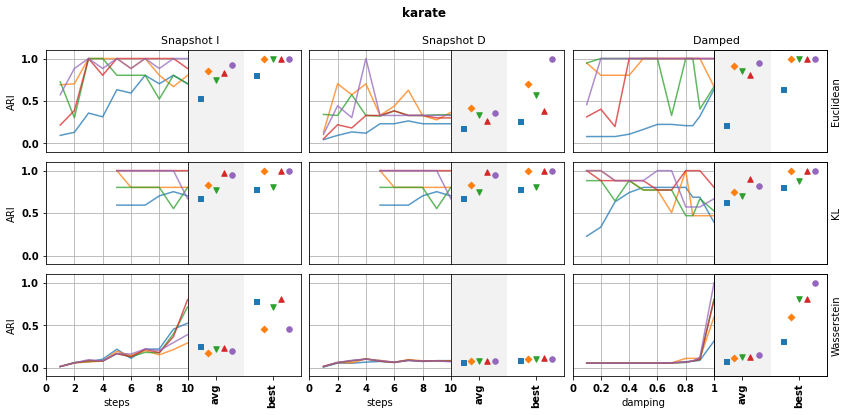

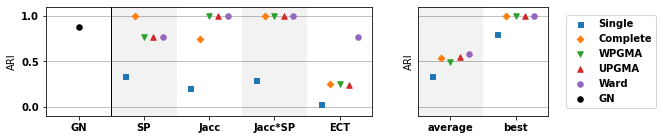

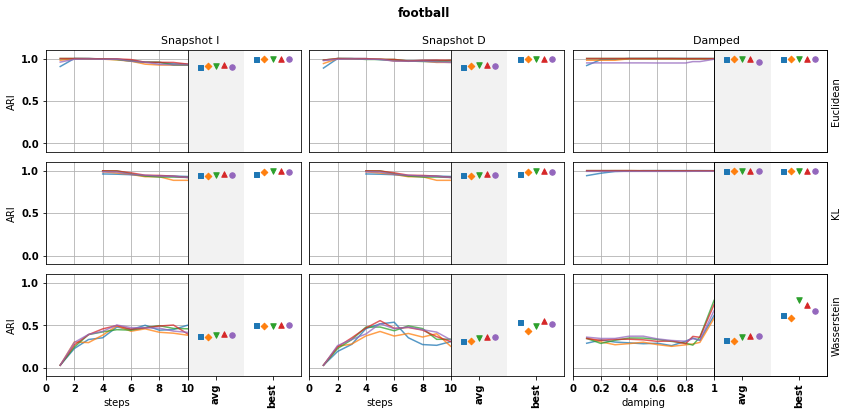

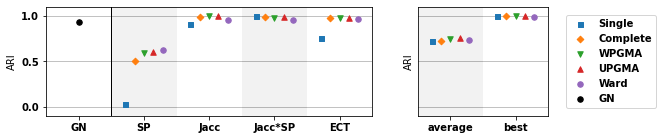

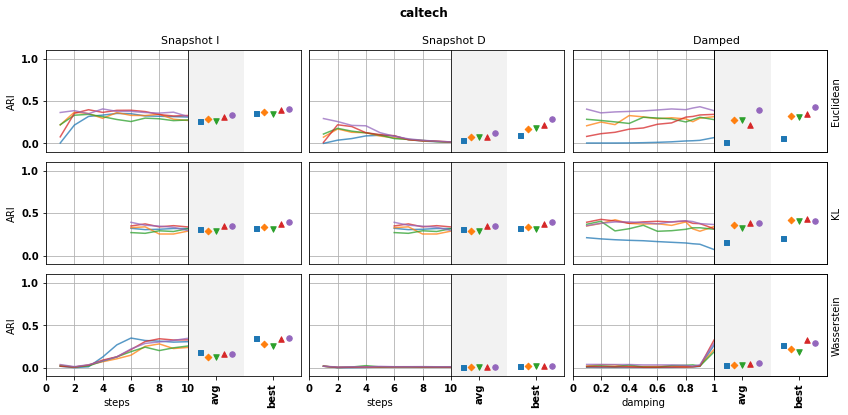

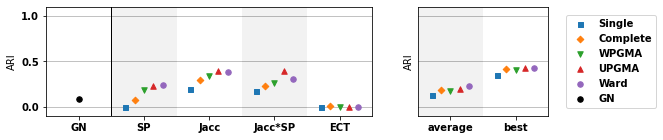

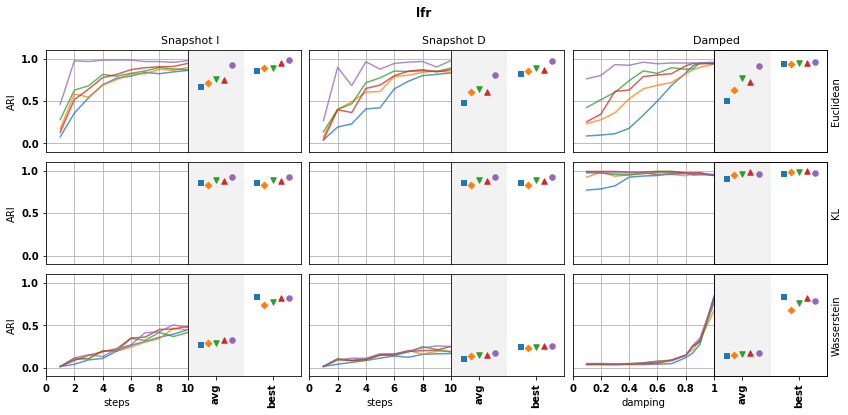

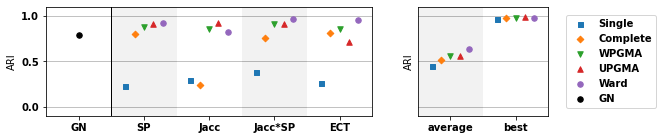

In [206]:
names = ['karate','football','caltech','lfr']
methods = ['single', 'complete', 'weighted', 'average', 'ward']
for name in names:
    plot_methods(name, methods)

In [136]:
def save_clustering(G, draw_dend=False):
    embedding = embed_snapshot_markov(G, 5, degrees=False)
    Z = cluster_walktrap(embedding, 'ward', True)
#     embedding = embed_damped_markov(G, .1)
#     Z = KL_symmetric(embedding, 'average', True)
    print(eval_ARI(G, Z))

    if draw_dend:
        draw_dendrogram(G, Z)
        
    root = to_tree(Z)
    with open(f'results/dendrogram_ward_{G.graph["name"]}.pkl', 'wb') as f:
        dump((G,root), f, HIGHEST_PROTOCOL)

In [60]:
draw = False
save_clustering(wrangle_karate(), draw)
save_clustering(wrangle_football(), draw)
save_clustering(wrangle_caltech(), draw)
save_clustering(generate_lfr(), draw)

(1.0, 2)
(0.9912266084718439, 14)
(0.37791646350546304, 22)
(0.982076562016823, 10)


# misc

In [ ]:
# try infomap

from infomap import Infomap
im = Infomap()
G = wrangle_caltech()
for i,j in G.edges:
    im.add_link(i,j)
im.run("--two-level --num-trials 5")
predicted = []
for node in im.tree:
    if node.is_leaf:
        predicted.append(node.module_id)
#         print(node.node_id, node.module_id)

gtruth = list(nx.get_node_attributes(G, 'cluster').values())
print(adjusted_rand_score(gtruth, predicted))

In [ ]:
# try pure modularity

from community import best_partition
G = wrangle_caltech()
predicted = list(best_partition(G).values())

gtruth = list(nx.get_node_attributes(G, 'cluster').values())
print(adjusted_rand_score(gtruth, predicted))

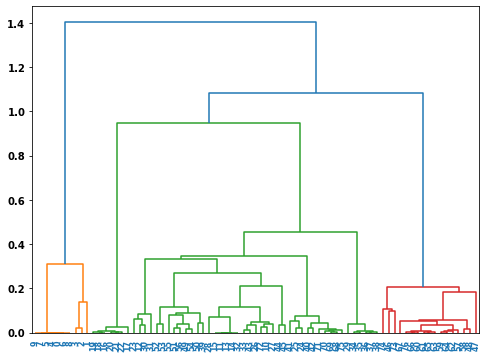

In [295]:
# lesmis figure

G = wrangle_lesmis()

# embedding = embed_damped_markov(G, .1)
# Z = KL_symmetric(embedding, 'average', True)
embedding = embed_snapshot_markov(G, 5, degrees=False)
Z = cluster_walktrap(embedding, 'ward', True)
# Z = girvan_newman(G)

# TODO: save names of characters to place around circle!
draw_dendrogram(G, Z, (8,6))
# plt.savefig('lesmis_dendrogram.png')
root = to_tree(Z)
with open(f'results/dendrogram_ward_lesmis.pkl', 'wb') as f:
    dump((G,root), f, HIGHEST_PROTOCOL)